In [1]:
pip install transformers torch datasets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load model and tokenizer
model_name = "silma-ai/SILMA-9B-Instruct-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# Text generation pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=15,
    temperature=0.1,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id
)

Device set to use cuda:0


In [8]:
# Load JSON dataset
with open("/teamspace/studios/this_studio/nlp/arsarcasm_test.json", "r", encoding="utf-8") as f:
    data = json.load(f)

def clean_output(output_text, prompt_length):
    return output_text[prompt_length:].strip()

In [9]:
def generate_and_parse(prompt, valid_options=None, default="UNKNOWN", max_attempts=3):
    """
    Generate text from LLM and attempt to parse into expected format.
    Shows raw response for debugging.
    Inspired by best practices: https://github.com/langchain-ai/langchain/issues/281
    """
    for attempt in range(max_attempts):  # Try multiple times
        raw_response = generator(prompt)[0]['generated_text'][len(prompt):].strip()
        print(f"[Attempt {attempt + 1}] 🤖 Raw LLM Response: '{raw_response}'")

        if not valid_options:
            return raw_response  # Return raw if no structure expected

        raw_upper = raw_response.upper()
        matched = [opt for opt in valid_options if opt.upper() in raw_upper]

        if matched:
            return matched[0]  # Return first match

        print("⚠️ No valid option found. Retrying...")

    print(f"❌ Failed to get valid response after {max_attempts} tries. Using fallback: {default}")
    return default

# Run predictions with real-time logging
for idx, item in enumerate(data):
    print(f"\n🔄 Processing Item {idx+1}/{len(data)}:")
    print("📄 Input text:", item["input"])

    try:
        sarcasm_prompt = (
            item["sarcasm_instruction"] +
            "\nReturn ONLY 'TRUE' or 'FALSE'.\nText: " + item["input"]
        )
        messages = [{"role": "user", "content": sarcasm_prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        item["predicted_sarcasm"] = generate_and_parse(formatted_prompt, valid_options=["TRUE", "FALSE"], default="FALSE")
        print("✅ Predicted Sarcasm:", item["predicted_sarcasm"])

        sentiment_prompt = (
            item["sentiment_instruction"] +
            "\nReturn ONLY one of these labels: 'POS', 'NEG', or 'NEU'.\nText: " + item["input"]
        )
        messages = [{"role": "user", "content": sentiment_prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        item["predicted_sentiment"] = generate_and_parse(formatted_prompt, valid_options=["POS", "NEG", "NEU"], default="NEU")
        print("✅ Predicted Sentiment:", item["predicted_sentiment"])

        dialect_prompt = (
            item["dialect_instruction"] +
            "\nReturn ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb'.\nText: " + item["input"]
        )
        messages = [{"role": "user", "content": dialect_prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        item["predicted_dialect"] = generate_and_parse(formatted_prompt, valid_options=["msa", "egypt", "gulf", "levant", "magreb"], default="msa")
        print("✅ Predicted Dialect:", item["predicted_dialect"])

    except Exception as e:
        print(f"[ERROR] Failed to process item {idx+1}: {e}")
        item["predicted_sarcasm"] = "FALSE"
        item["predicted_sentiment"] = "NEU"
        item["predicted_dialect"] = "msa"

# Save updated dataset with predictions
with open("dataset_with_predictions_first5.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)


🔄 Processing Item 1/3000:
📄 Input text: اخوي حانق يالغلا وشفيك معصب عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان
[Attempt 1] 🤖 Raw LLM Response: 'FALSE'
✅ Predicted Sarcasm: FALSE


[Attempt 1] 🤖 Raw LLM Response: 'POS'
✅ Predicted Sentiment: POS
[Attempt 1] 🤖 Raw LLM Response: 'egypt'
✅ Predicted Dialect: egypt

🔄 Processing Item 2/3000:
📄 Input text: اف مو متعوده عليهم سته
[Attempt 1] 🤖 Raw LLM Response: 'TRUE'
✅ Predicted Sarcasm: TRUE
[Attempt 1] 🤖 Raw LLM Response: 'NEU'
✅ Predicted Sentiment: NEU
[Attempt 1] 🤖 Raw LLM Response: 'egypt'
✅ Predicted Dialect: egypt

🔄 Processing Item 3/3000:
📄 Input text: اللهم اشف مرضانا ومرضى المسلمين
[Attempt 1] 🤖 Raw LLM Response: 'FALSE'
✅ Predicted Sarcasm: FALSE
[Attempt 1] 🤖 Raw LLM Response: 'POS'
✅ Predicted Sentiment: POS
[Attempt 1] 🤖 Raw LLM Response: 'msa'
✅ Predicted Dialect: msa

🔄 Processing Item 4/3000:
📄 Input text: ابشركم طلقت السات
[Attempt 1] 🤖 Raw LLM Response: 'TRUE'
✅ Predicted Sarcasm: TRUE
[Attempt 1] 🤖 Raw LLM Response: 'POS'
✅ Predicted Sentiment: POS
[Attempt 1] 🤖 Raw LLM Response: 'egypt'
✅ Predicted Dialect: egypt

🔄 Processing Item 5/3000:
📄 Input text: مؤشر خطير ٩٠ من الشخصيات البرلمانية في الك

📊 Sarcasm Confusion Matrix & Metrics:


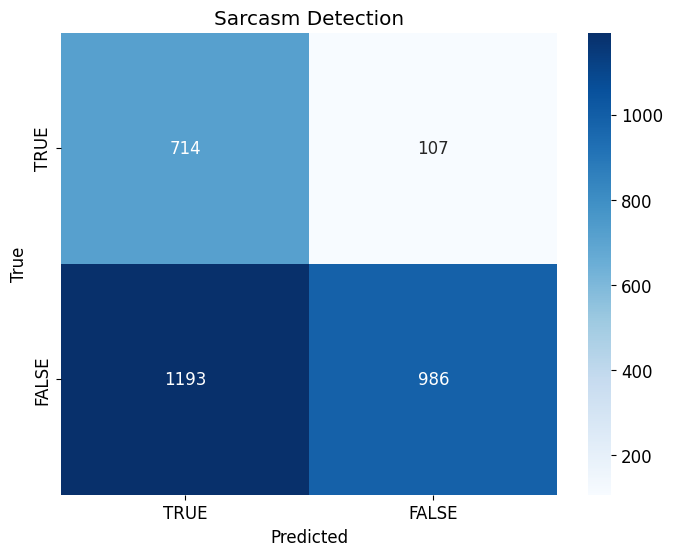

              precision    recall  f1-score   support

        TRUE       0.37      0.87      0.52       821
       FALSE       0.90      0.45      0.60      2179

    accuracy                           0.57      3000
   macro avg       0.64      0.66      0.56      3000
weighted avg       0.76      0.57      0.58      3000

✅ Overall Macro F1-Score: 0.5631

📊 Sentiment Confusion Matrix & Metrics:


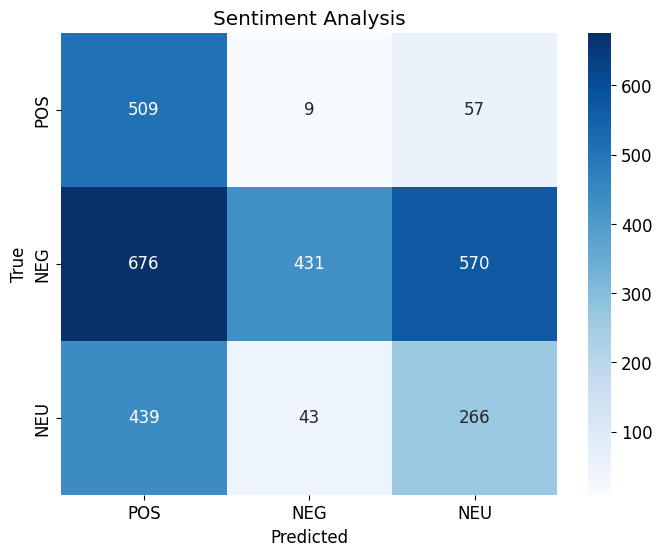

              precision    recall  f1-score   support

         POS       0.31      0.89      0.46       575
         NEG       0.89      0.26      0.40      1677
         NEU       0.30      0.36      0.32       748

    accuracy                           0.40      3000
   macro avg       0.50      0.50      0.40      3000
weighted avg       0.63      0.40      0.39      3000

✅ Overall Macro F1-Score: 0.3954

📊 Dialect Confusion Matrix & Metrics:


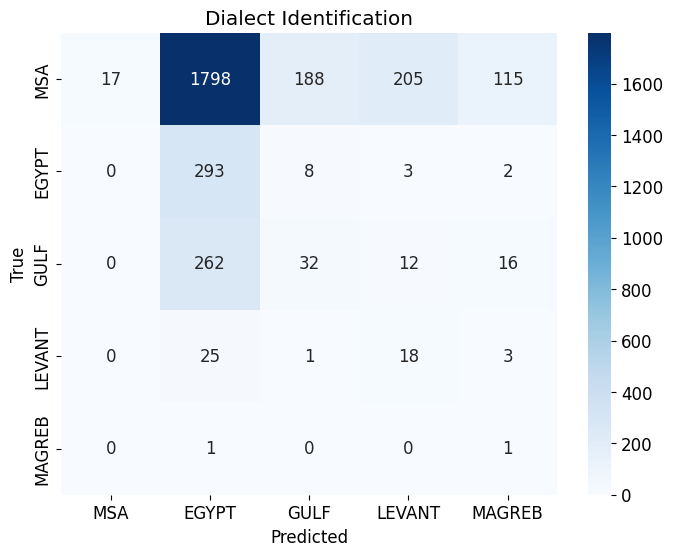

              precision    recall  f1-score   support

         MSA       1.00      0.01      0.01      2323
       EGYPT       0.12      0.96      0.22       306
        GULF       0.14      0.10      0.12       322
      LEVANT       0.08      0.38      0.13        47
      MAGREB       0.01      0.50      0.01         2

    accuracy                           0.12      3000
   macro avg       0.27      0.39      0.10      3000
weighted avg       0.80      0.12      0.05      3000

✅ Overall Macro F1-Score: 0.0979



0.09792723555072554

In [10]:
# Normalize all labels to uppercase for evaluation
valid_sentiment = {"POS", "NEG", "NEU"}
valid_dialect = {"MSA", "EGYPT", "GULF", "LEVANT", "MAGREB"}

true_sarcasm = ["TRUE" if item["is_sarcastic"] else "FALSE" for item in data]
pred_sarcasm = [item["predicted_sarcasm"].upper() for item in data]

true_sentiment = [item["sentiment"].upper() for item in data]
pred_sentiment = [item["predicted_sentiment"].upper() if item["predicted_sentiment"].upper() in valid_sentiment else "NEU" for item in data]

true_dialect = [item["dialect"].upper() for item in data]
pred_dialect = [item["predicted_dialect"].upper() if item["predicted_dialect"].upper() in valid_dialect else "MSA" for item in data]

# Set global font size for plots
plt.rcParams.update({'font.size': 12})

# Helper function to plot confusion matrix and return metrics
def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

    # F1-score macro average 
    macro_f1 = f1_score(y_true, y_pred, average='macro', labels=labels)
    print(f"✅ Overall Macro F1-Score: {macro_f1:.4f}\n")
    return macro_f1

# Define label sets
sarcasm_labels = ["TRUE", "FALSE"]
sentiment_labels = ["POS", "NEG", "NEU"]
dialect_labels = ["MSA", "EGYPT", "GULF", "LEVANT", "MAGREB"]

# Plot confusion matrices and show metrics
print("📊 Sarcasm Confusion Matrix & Metrics:")
plot_confusion_matrix(true_sarcasm, pred_sarcasm, "Sarcasm Detection", sarcasm_labels)

print("📊 Sentiment Confusion Matrix & Metrics:")
plot_confusion_matrix(true_sentiment, pred_sentiment, "Sentiment Analysis", sentiment_labels)

print("📊 Dialect Confusion Matrix & Metrics:")
plot_confusion_matrix(true_dialect, pred_dialect, "Dialect Identification", dialect_labels)